In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Load files into DataFrames
X_training_set = pd.read_csv("./data/X_train.csv")
print(type(X_training_set), X_training_set.shape)

<class 'pandas.core.frame.DataFrame'> (1397533, 12)


5.0    746520
4.0    315587
3.0    165727
1.0     85615
2.0     84084
Name: Score, dtype: int64


Id                         0
ProductId                  0
UserId                     0
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   19
Text                      53
Helpfulness                0
ProductMean                0
UserMean                   0
dtype: int64

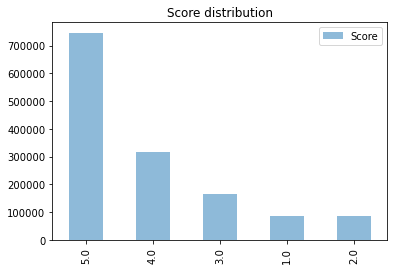

In [2]:
count_first = X_training_set['Score'].value_counts()
print(count_first)
plt.title('Score distribution')
count_first.plot(kind='bar', legend=True, alpha=.5)
# highly skewness, consider cut part of records with score 5
X_training_set.isna().sum()

123958 50050


<AxesSubplot:title={'center':'5 Most Rated User'}>

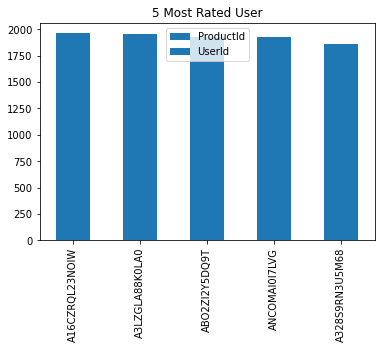

In [3]:
from datetime import datetime
X_training_set['Time'] = X_training_set['Time'].apply(lambda t: datetime.fromtimestamp(t))

num_user = X_training_set['UserId'].nunique()
num_product = X_training_set['ProductId'].nunique()
print(num_user, num_product)
plt.title('5 Most Rated Products')
X_training_set['ProductId'].value_counts(sort=True).nlargest(5).plot(kind='bar', legend=True)

plt.title('5 Most Rated User')
X_training_set['UserId'].value_counts(sort=True).nlargest(5).plot(kind='bar', legend=True)

In [4]:
X_training_set = X_training_set.dropna(how='any', subset=['Summary', 'Text'])

X_training_set['Comment'] = X_training_set[['Summary', 'Text']].apply(lambda x: ', '.join(x), axis=1)

In [5]:
X_training_set = X_training_set.drop(X_training_set.query('Score == 5').sample(frac=.6).index)
count_second = X_training_set['Score'].value_counts()
print(count_second)

4.0    315572
5.0    298592
3.0    165720
1.0     85609
2.0     84079
Name: Score, dtype: int64


In [6]:
X_train_processed = X_training_set.drop(columns=['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Text', 'Summary', 'Helpfulness'])
X_train_processed.head()

,Score,ProductMean,UserMean,Comment
0,4.0,4.483871,4.333333,"good version of a classic, This is a charming ..."
1,3.0,4.483871,3.600000,"Good but not as moving, It was good but not as..."
2,3.0,4.483871,3.800000,"Winkler's Performance was ok at best!, Don't g..."
3,5.0,4.483871,3.600000,"It's an enjoyable twist on the classic story, ..."
4,4.0,4.483871,4.176471,"Best Scrooge yet, This is one of the best Scro..."


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_processed[['Comment', 'ProductMean', 'UserMean']],
    X_train_processed['Score'],
    test_size=1/5.0,
    random_state=0
)

In [8]:
import scipy.sparse
from scipy.sparse import csr_matrix

Product_matrix_train = csr_matrix(X_train['ProductMean'])
print(type(Product_matrix_train), Product_matrix_train.shape)
User_matrix_train = csr_matrix(X_train['UserMean'])
print(type(User_matrix_train), User_matrix_train.shape)
Product_matrix_test = csr_matrix(X_test['ProductMean'])
print(type(Product_matrix_test), Product_matrix_test.shape)
User_matrix_test = csr_matrix(X_test['UserMean'])
print(type(User_matrix_test), User_matrix_test.shape)
Average_matrix_train = scipy.sparse.vstack([Product_matrix_train, User_matrix_train])
Average_matrix_test = scipy.sparse.vstack([Product_matrix_test, User_matrix_test])

"""
from sklearn.preprocessing import normalize
Average_matrix_train = normalize(Average_matrix_train, norm='l1', axis=0)
Average_matrix_test = normalize(Average_matrix_test, norm='l1', axis=0)
"""

print(type(Average_matrix_train), Average_matrix_train.shape)
print(type(Average_matrix_test), Average_matrix_test.shape)

<class 'scipy.sparse.csr.csr_matrix'> (1, 759657)
<class 'scipy.sparse.csr.csr_matrix'> (1, 759657)
<class 'scipy.sparse.csr.csr_matrix'> (1, 189915)
<class 'scipy.sparse.csr.csr_matrix'> (1, 189915)
<class 'scipy.sparse.csr.csr_matrix'> (2, 759657)
<class 'scipy.sparse.csr.csr_matrix'> (2, 189915)


In [9]:
text_vectorizer = TfidfVectorizer(stop_words='english', min_df = 3, max_df = 0.9, token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")
X_train_comment = X_train.drop(columns=['UserMean', 'ProductMean'])
X_test_comment = X_test.drop(columns=['UserMean', 'ProductMean'])
data_train = text_vectorizer.fit_transform(X_train_comment['Comment'])
print(type(data_train), data_train.shape)
data_test = text_vectorizer.transform(X_test_comment['Comment'])
print(type(data_test), data_test.shape)

<class 'scipy.sparse.csr.csr_matrix'> (759657, 150363)
<class 'scipy.sparse.csr.csr_matrix'> (189915, 150363)


In [10]:
total_train = scipy.sparse.hstack([Average_matrix_train.T, data_train])
total_test = scipy.sparse.hstack([Average_matrix_test.T, data_test])
print(type(total_train), total_train.shape)
print(type(total_test), data_test.shape)

<class 'scipy.sparse.coo.coo_matrix'> (759657, 150365)
<class 'scipy.sparse.coo.coo_matrix'> (189915, 150363)


In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import sklearn.svm as svm
import sklearn.model_selection as model_selection

model = LogisticRegression(random_state = 0, C = 4, max_iter = 500).fit(total_train, Y_train)
Y_predict = model.predict(total_test)

"""
model = svm.SVC(kernel = 'linear').fit(total_train, Y_train)
Y_predict = model.predict(total_test)

# take too long to run
model = RandomForestClassifier(n_estimators=100).fit(total_train, Y_train)
Y_predict = model.predict(total_test)
"""

MSE = mean_squared_error(Y_predict, Y_test)
print("MSE is " + str(MSE))
print(classification_report(Y_test,Y_predict))

/Users/xukaiyan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MSE is 0.6994181607561277
              precision    recall  f1-score   support

         1.0       0.65      0.65      0.65     17238
         2.0       0.43      0.32      0.37     16890
         3.0       0.48      0.42      0.45     33208
         4.0       0.57      0.63      0.60     63195
         5.0       0.71      0.73      0.72     59384

    accuracy                           0.60    189915
   macro avg       0.57      0.55      0.56    189915
weighted avg       0.59      0.60      0.59    189915



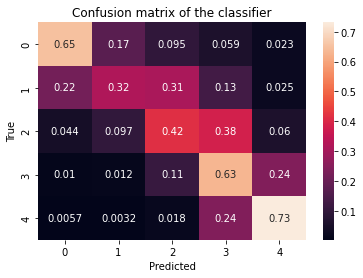

In [12]:
cm = confusion_matrix(Y_test, Y_predict, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
X_submission_set = pd.read_csv("./data/X_test.csv")
print(X_submission_set.isna().sum())

Id                             0
ProductId                      0
UserId                         0
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Time                           0
Summary                        6
Text                           9
Helpfulness                    0
ProductMean                   10
UserMean                      10
Score                     300000
dtype: int64


In [14]:
X_submission_set['ProductMean'] = X_submission_set['ProductMean'].fillna(X_submission_set['ProductMean'].mean())
X_submission_set['UserMean'] = X_submission_set['UserMean'].fillna(X_submission_set['UserMean'].mean())
X_submission_set['Summary'] = X_submission_set['Summary'].fillna(value = 'none')
X_submission_set['Text'] = X_submission_set['Text'].fillna(value = 'none')

X_submission_set['Comment'] = X_submission_set[['Summary', 'Text']].apply(lambda y: ', '.join(y), axis=1)
X_submission_processed = X_submission_set.drop(columns=['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Text', 'Summary', 'Helpfulness'])
print(type(X_submission_processed), X_submission_processed.shape)

Product_matrix_submission = csr_matrix(X_submission_processed['ProductMean'])
User_matrix_submission = csr_matrix(X_submission_processed['UserMean'])
Average_matrix_submission = scipy.sparse.vstack([Product_matrix_submission, User_matrix_submission])

X_submission_comment = X_submission_processed.drop(columns=['UserMean', 'ProductMean'])
data_submission = text_vectorizer.transform(X_submission_comment['Comment'])

total_submission = scipy.sparse.hstack([Average_matrix_submission.T, data_submission])
# submission_normalized = normalize(total_submission, norm='l1', axis=0)

Score_predict = model.predict(total_submission)
print(type(Score_predict), Score_predict.shape)

X_submission_set['Score'] = Score_predict
submission = X_submission_set[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

<class 'pandas.core.frame.DataFrame'> (300000, 4)
<class 'numpy.ndarray'> (300000,)
